In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

### Preprocess data

1. Read data

In [143]:
df = pd.read_csv("./optimization_data/country_minMaxI2000000_controls.csv", sep=';')

In [144]:
df.head(10)

,tydzien,grupa,teryt,Psi,Phi,u,u_rel
0,0,young,poland,0.965674,NaN,NaN,NaN
1,0,middle_aged,poland,0.999867,NaN,NaN,NaN
2,0,old,poland,1.000000,NaN,NaN,NaN
3,1,young,poland,0.997638,NaN,NaN,NaN
4,1,middle_aged,poland,0.986698,NaN,NaN,NaN
5,1,old,poland,0.986788,NaN,NaN,NaN
6,2,young,poland,0.963565,NaN,NaN,NaN
7,2,middle_aged,poland,0.700037,NaN,NaN,NaN
8,2,old,poland,0.700000,NaN,NaN,NaN
9,3,young,poland,0.700000,NaN,NaN,NaN


2. Drop unused columns

In [145]:
df.drop(columns=['teryt','Phi', 'u', 'u_rel'], axis=1, inplace=True)

3. Map Phi to Stringency Index

In [146]:
df['Si'] = np.interp(df.Psi, [0.7, 1], [1, 0])

4. Split data for three age groups

In [147]:
df_young = df[df.grupa == "young"][['tydzien', 'Si']]
df_middle = df[df.grupa == "middle_aged"][['tydzien', 'Si']]
df_old = df[df.grupa == "old"][['tydzien', 'Si']]

5. Add Date as an index to each dataframe

In [148]:
df_young.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)
df_middle.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)
df_old.set_index(pd.date_range(start='1/3/2021', periods=26, freq='W'), inplace=True)

In [149]:
df_young.head(10)

,tydzien,Si
2021-01-03,0,0.114420
2021-01-10,1,0.007873
2021-01-17,2,0.121450
2021-01-24,3,1.000000
2021-01-31,4,1.000000
2021-02-07,5,1.000000
2021-02-14,6,1.000000
2021-02-21,7,1.000000
2021-02-28,8,1.000000
2021-03-07,9,0.847523


### Stringency Index

In [155]:
def plot_si(df):
    plt.plot(df.Si)
    plt.xlabel('Date')
    plt.ylabel('Stringency Index')
    plt.title('Stringency index')
    plt.xticks(rotation=45)
    plt.show()

Young

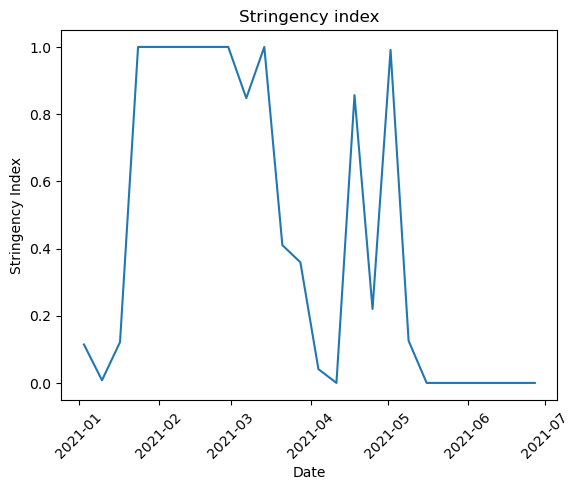

In [156]:
plot_si(df_young)

Middle-aged

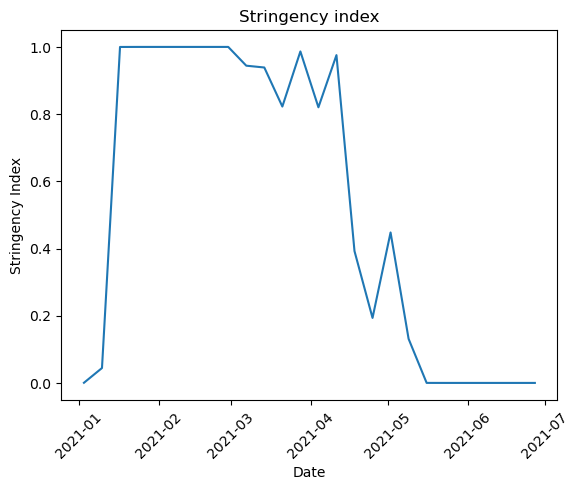

In [157]:
plot_si(df_middle)

Old

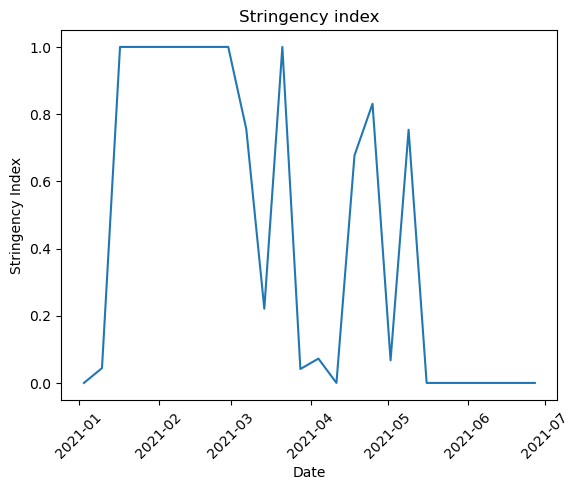

In [158]:
plot_si(df_old)

### Recursive predictions

In [159]:
npis = [
    "C1M",
    "C2M",
    "C3M",
    "C4M",
    "C5M",
    "C6M",
    "C7M",
    "C8M",
    "H1"
]

npi_labels = [
    "School closing",
    "Workplace closing",
    "Cancel public events",
    "Restrictions on gatherings",
    "Close public transport",
    "Stay at home requirements",
    "Restrictions on internal movement",
    "International travel controls",
    "Public information campaigns"
]

In [160]:
mtl_model = load_model("./models/mtl_model_all.h5")
num_tasks = 9
num_features = num_tasks + 1

In [169]:
def iterative_predict(init, indexes):
    f = lambda x: np.argmax(x, axis=-1)
    iterative_predictions = []

    for j in range(0, len(indexes)):
        predictions = mtl_model.predict(
            x=init.reshape(-1, num_features),
            batch_size=10,
            verbose=0)
        predictions = np.array(predictions)
        predictions = f(predictions)
        init = np.concatenate(([indexes[j]], predictions.flatten()))
        iterative_predictions.append(predictions.flatten())

    return list(zip(*iterative_predictions))

In [170]:
def two_step_plots(xlabel, ylabel, xvalue1, yvalue1, title, spacing):
    fig, ax = plt.subplots()
    ax.step(xvalue1, yvalue1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)  # Adjust the rotation angle as needed
    plt.xticks(range(0, len(xvalue1), spacing))  # Display every second label
    # plt.tight_layout()  # Optional: adjust layout to prevent label overlapping
    plt.show()

In [171]:
def plot_predictions(df_age):
    init = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

    indexes = df_age['Si'].tolist()
    indexes_no_first = indexes[1:]
    long_term_predictions = iterative_predict(init=init, indexes=indexes_no_first)

    for i in range(0, 9):
        two_step_plots(xlabel='Date', ylabel=npis[i], xvalue1=range(len(long_term_predictions[i])),
              yvalue1=long_term_predictions[i], title=npi_labels[i], spacing=20)

Young

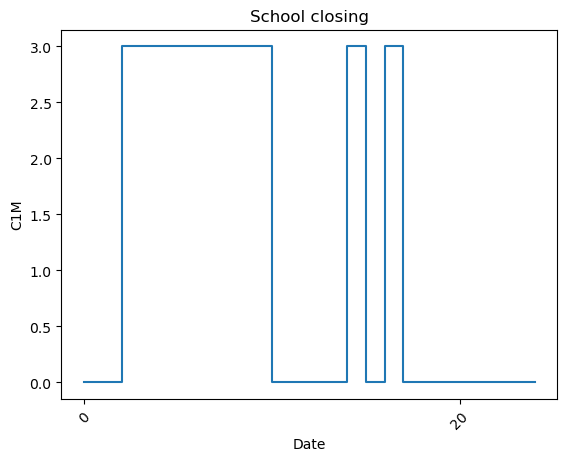

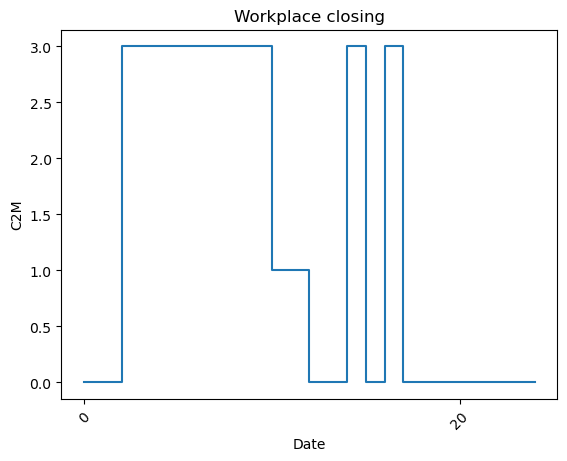

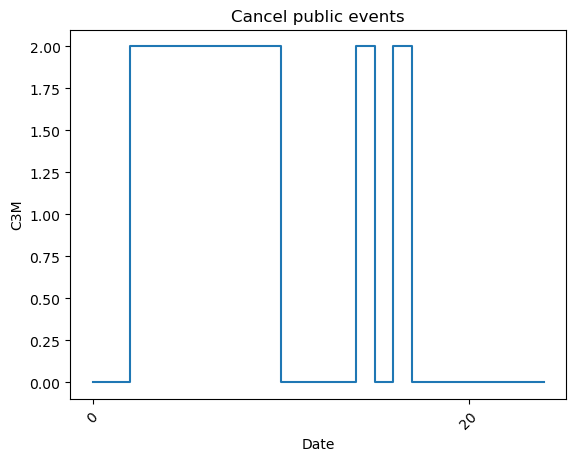

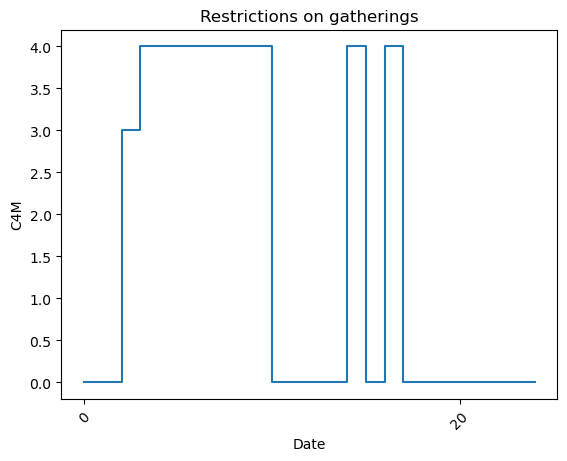

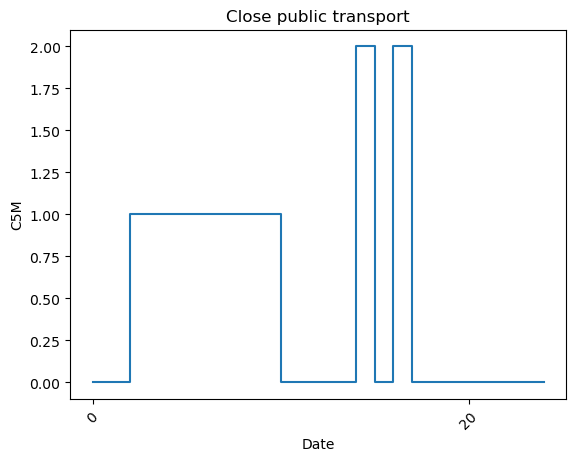

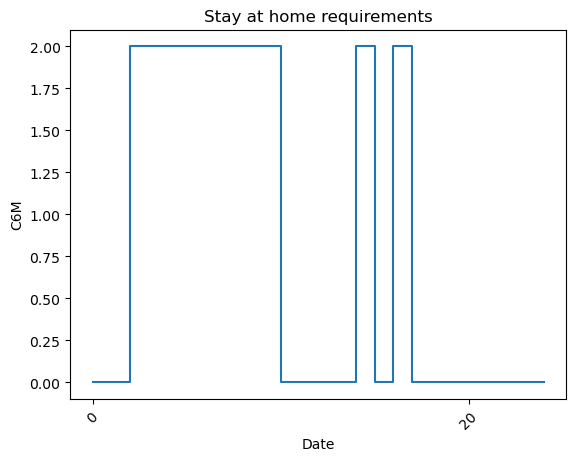

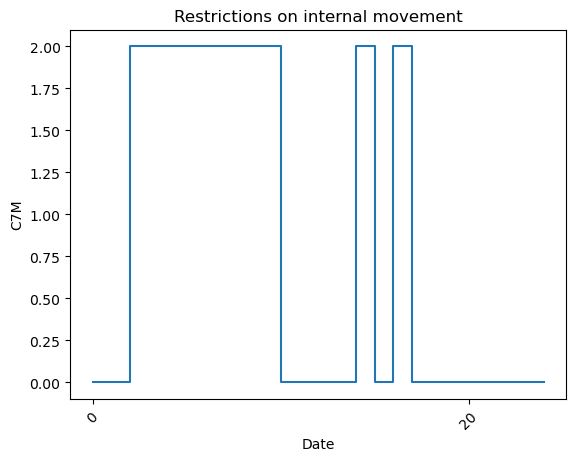

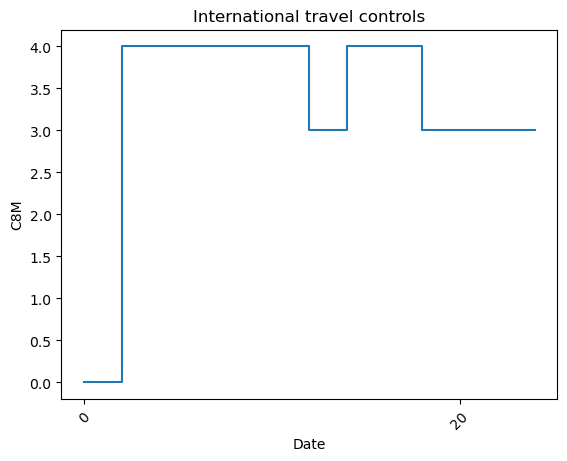

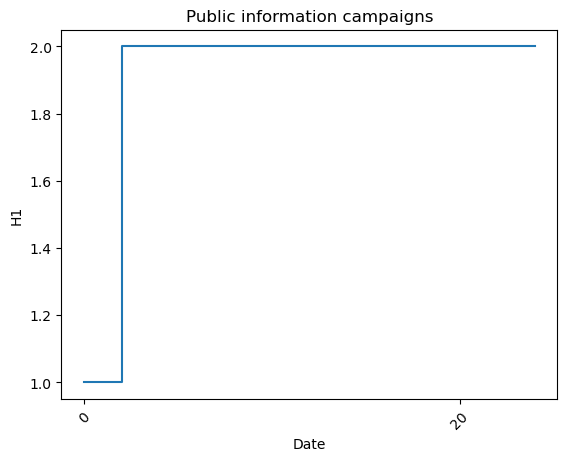

In [172]:
plot_predictions(df_young)

Middle-aged

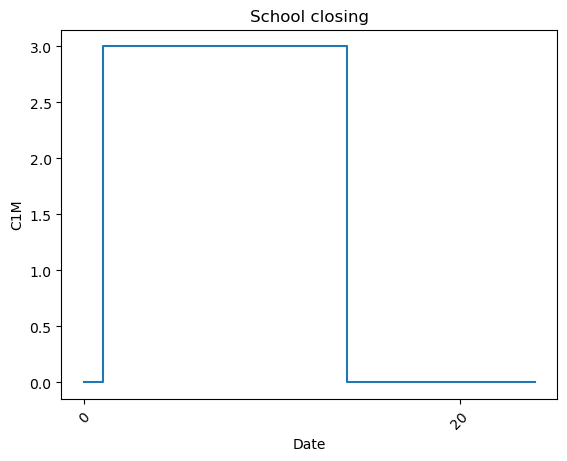

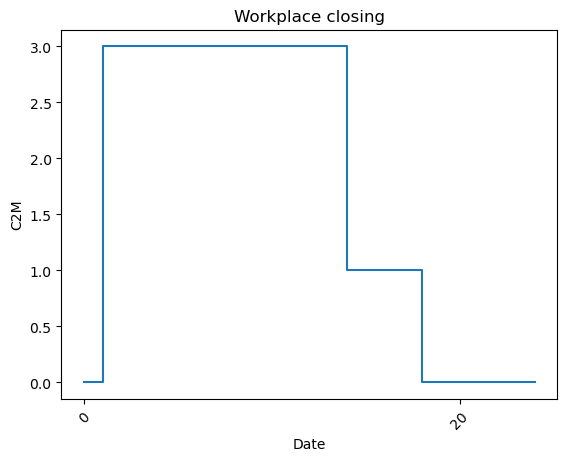

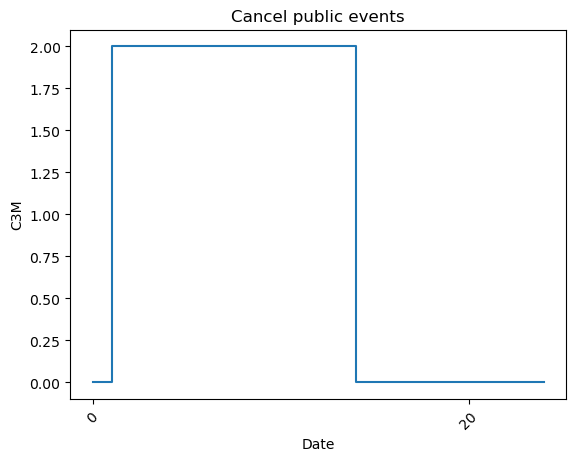

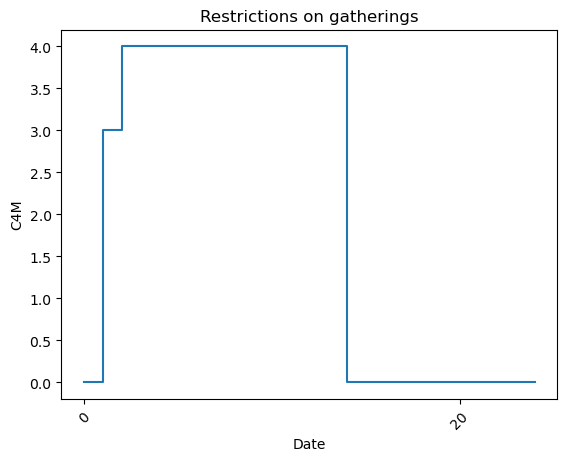

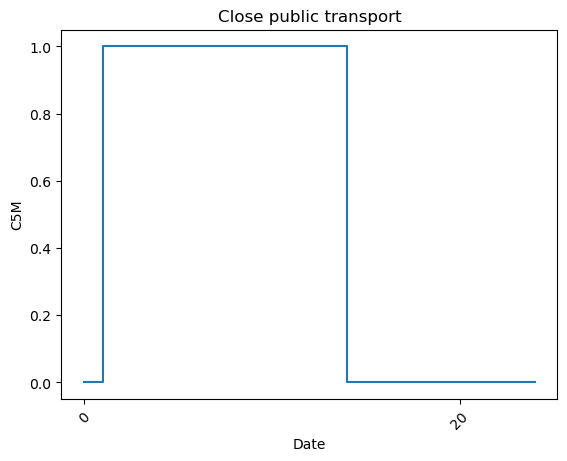

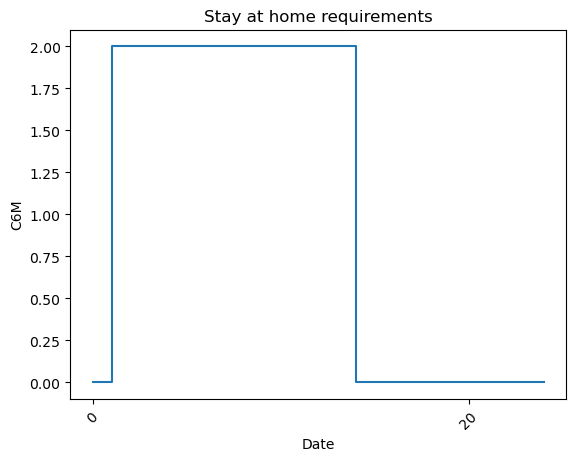

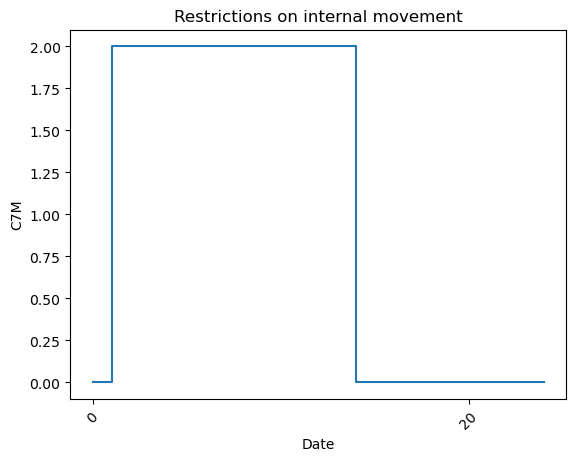

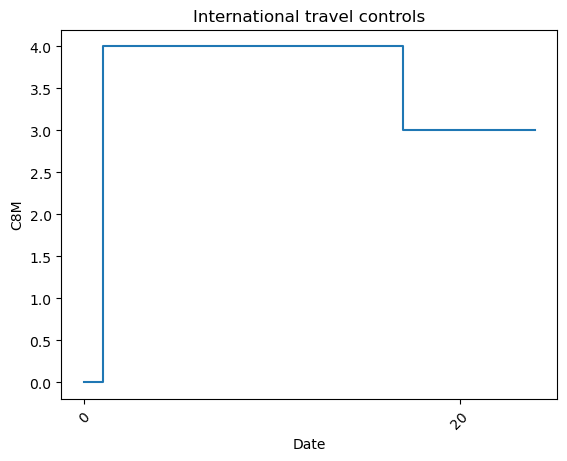

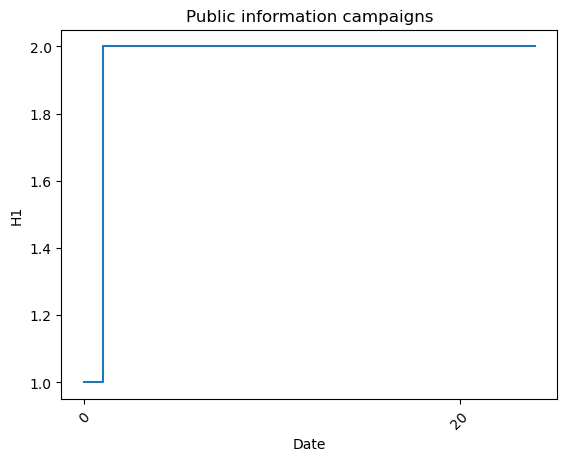

In [173]:
plot_predictions(df_middle)

Old

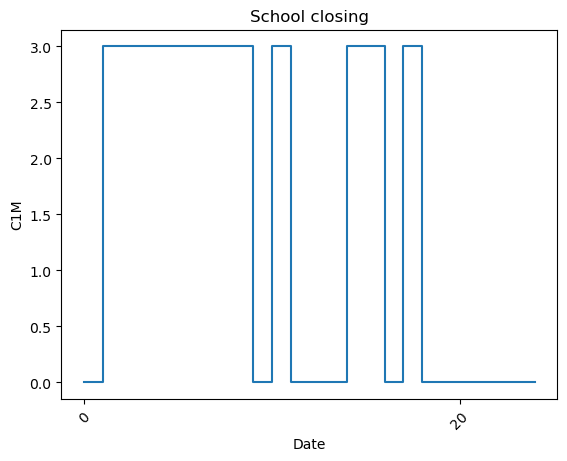

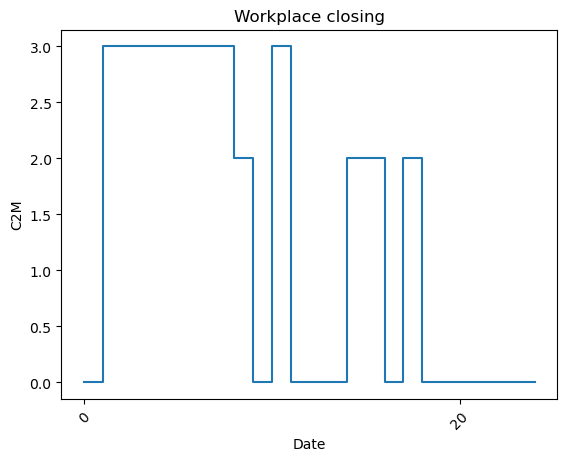

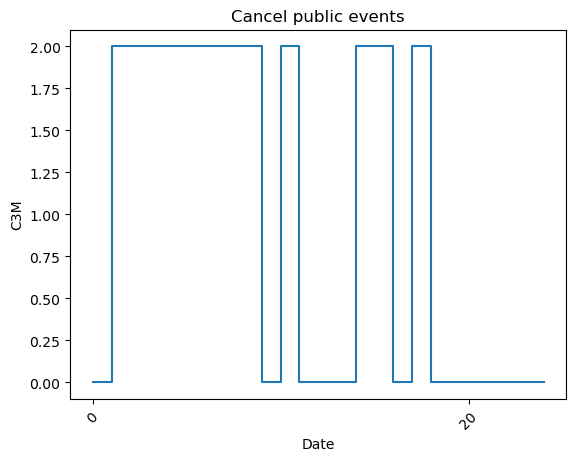

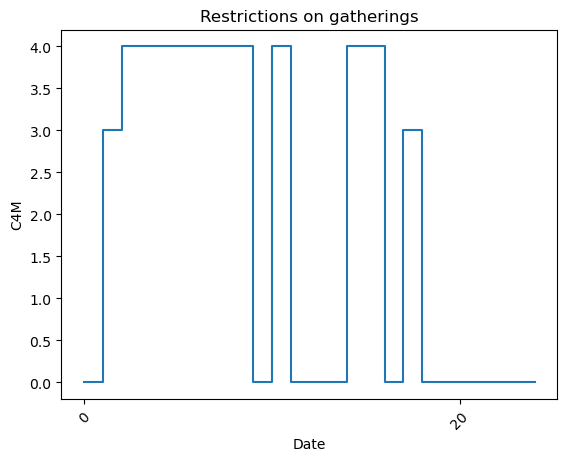

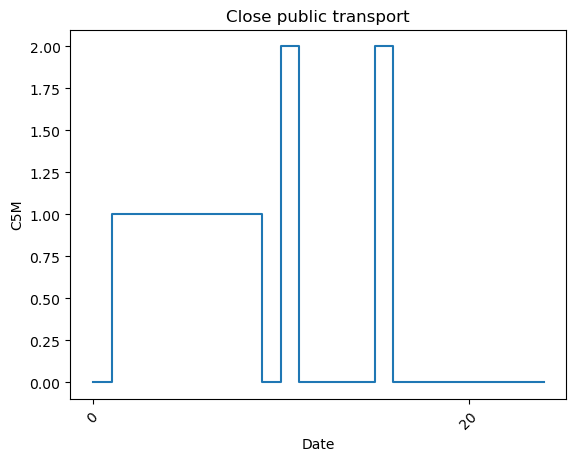

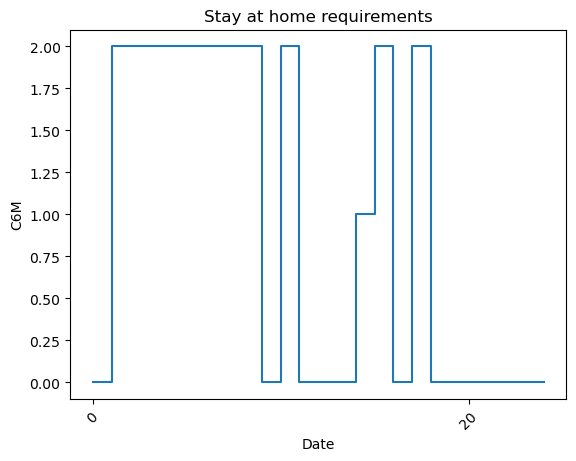

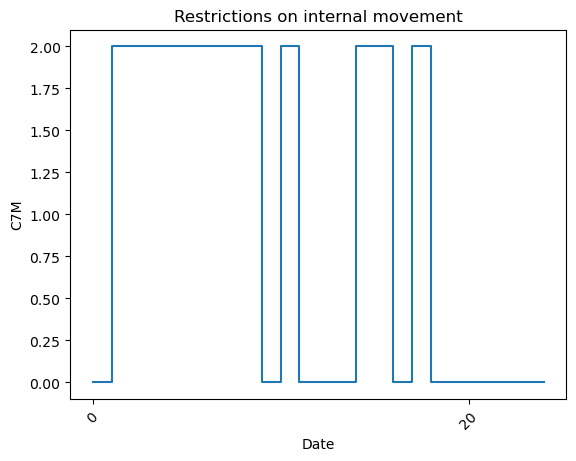

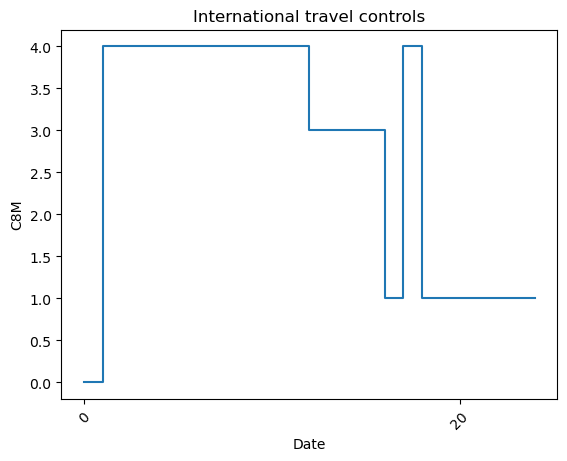

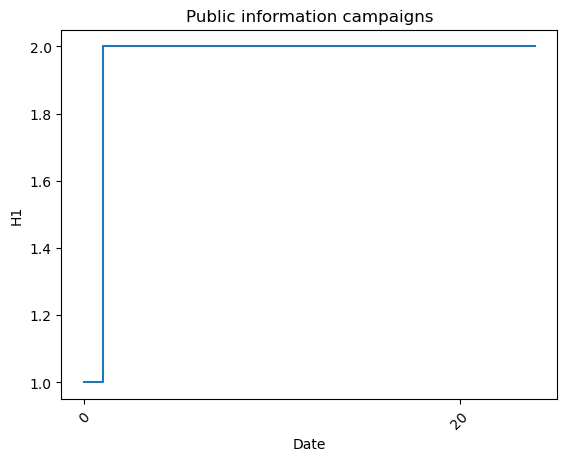

In [174]:
plot_predictions(df_old)